# Does a _Doppler_ fit to pre-LOS Goldstone data explain the SSN residuals?


In [1]:
from astropy import units as u
sampling_interval = 1*u.minute
pre_los_tracking_period = 1*u.day

In [2]:
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, ssrAltair, ssrMillstone
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory
from sim.util import orbit_from_horizons, make_epochs
from sim.fitorbit import OrbitFitter

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
goldstone_start = goldstone_end - pre_los_tracking_period
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value

In [4]:
pre_los_orbit = orbit_from_horizons("NEAR", goldstone_start)
describe_orbit(pre_los_orbit)

pre_los_epochs = make_epochs(goldstone_start, goldstone_end, sampling_interval)
print("Start and end epochs:", goldstone_start, pre_los_epochs[-1], "[", pre_los_epochs.size, "]")

pre_los_ephem = pre_los_orbit.to_ephem(EpochsArray(pre_los_epochs))
describe_trajectory(pre_los_ephem, dss25)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 108.20683493012913 deg
Eccentricity: 1.8160486629455659
Semilatus rectum: 19506.375499300964 km
Semimajor axix: -8488.293098378215 km
Periapse radius: 6926.860233621617 km , altitude: 548.7236336216174 km
Start and end epochs: 1998-01-22 06:14:55.600 1998-01-23 06:13:55.600 [ 1440 ]

::TRAJECTORY::
Start and end ranges: 643407.9945721263 km 31915.610959342797 km
Start and end radial speeds: -6.835206031703699 km / s -7.6830498766621105 km / s
Closest: 31915.610959342797 km speed 8.248486713273833 km / s  at  1998-01-23 06:13:55.600
Deflection: 1.520787768180591 deg


In [5]:
ref_data = []
sim_meas_data = []
for e in pre_los_epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss25.range_rate_accel(pre_los_ephem, e)
    ref_data.append(ref_rr)
    sim_meas_data.append([ref_rr - (ref_ra+ref_rs)*ref_r/const.c])

print(ref_data)
print(sim_meas_data)

[<Quantity -6.83520603 km / s>, <Quantity -6.83377021 km / s>, <Quantity -6.83233654 km / s>, <Quantity -6.83090506 km / s>, <Quantity -6.82947578 km / s>, <Quantity -6.82804875 km / s>, <Quantity -6.82662399 km / s>, <Quantity -6.82520153 km / s>, <Quantity -6.8237814 km / s>, <Quantity -6.82236362 km / s>, <Quantity -6.82094823 km / s>, <Quantity -6.81953526 km / s>, <Quantity -6.81812473 km / s>, <Quantity -6.81671668 km / s>, <Quantity -6.81531113 km / s>, <Quantity -6.81390811 km / s>, <Quantity -6.81250765 km / s>, <Quantity -6.81110978 km / s>, <Quantity -6.80971453 km / s>, <Quantity -6.80832193 km / s>, <Quantity -6.806932 km / s>, <Quantity -6.80554477 km / s>, <Quantity -6.80416028 km / s>, <Quantity -6.80277854 km / s>, <Quantity -6.8013996 km / s>, <Quantity -6.80002347 km / s>, <Quantity -6.79865019 km / s>, <Quantity -6.79727978 km / s>, <Quantity -6.79591227 km / s>, <Quantity -6.79454769 km / s>, <Quantity -6.79318607 km / s>, <Quantity -6.79182744 km / s>, <Quantity -

In [7]:
fitter = OrbitFitter(pre_los_orbit, [dss25], debug=True)
fitter.fit_doppler_data(pre_los_epochs[:-1], sim_meas_data)
print(fitter.report())
print(fitter.runtime)

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

Range constraints:
a: -8479804.805279836 -8496781.391476592
ecc: 1.8142326142826204 1.8178647116085112
inc: 1.8866769771500689 1.8904541082354542
max iter: 100
-1. 0.2112432538197401 {'a': -8488293.098378215, 'ecc': 1.8160486629455659, 'inc': 1.8885655426927617, 'nu': -2.1342580630292427, 'raan': 1.5419023957775935, 'argp': 2.5328065001701643}
0. 0.2112432538197401 {'a': -8488293.098378215, 'ecc': 1.8160486629455659, 'inc': 1.8885655426927617, 'nu': -2.1342580630292427, 'raan': 1.5419023957775935, 'argp': 2.5328065001701643}
1. 0.2112432538197401 {'a': -8488293.098378215, 'ecc': 1.8160486629455659, 'inc': 1.8885655426927617, 'nu': -2.1342580630292427, 'raan': 1.5419023957775935, 'argp': 2.5328065001701643}
2. 0.2112432538197401 {'a': -8488293.098378215, 'ecc': 1.8160486629455659, 'inc': 1.8885655426927617, 'nu': -2.1342580630292427, 'raan': 1.5419023957775935, 'argp': 2.5328065001701643}
3. 0.2112432538197401 {'a': -8488293.098378215, 'ecc': 1.8160486629455659, 'inc': 1.888565542692761

In [8]:
ssn_epochs = make_epochs(ssn_start, ssn_end, sampling_interval)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [17]:
sim_ssn_ephem = fitter.orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(sim_ssn_ephem, dss25)

# also extend the reference trajectory
pre_los_extended_ephem = pre_los_orbit.to_ephem(EpochsArray(ssn_epochs))


::TRAJECTORY::
Start and end ranges: 32344.692961056346 km 14233.874593167695 km
Start and end radial speeds: -7.679448266309836 km / s -6.899627724719007 km / s
Closest: 14233.874593167695 km speed 9.443733887227342 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.3513118865575056 deg


In [18]:
altair_residuals = []
millstone_residuals = []

for e in ssn_epochs:
    sim_rv = sim_ssn_ephem.rv(e)
    ref_rv = pre_los_extended_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(sim_rv, e)
    altair_residuals.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(sim_rv, e)
    millstone_residuals.append((meas_r - ref_r).to_value(u.m))

The residuals are almost doubled, though with smaller variation!


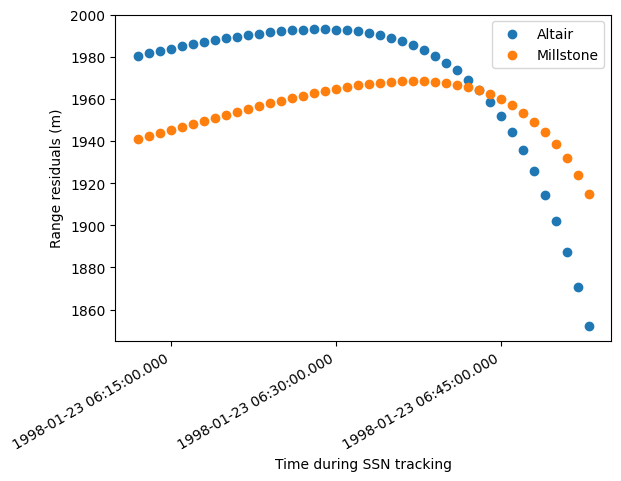

In [19]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Time during SSN tracking')
    plt.ylabel('Range residuals (m)')
    plt.scatter(ssn_epochs, altair_residuals, label="Altair")
    plt.scatter(ssn_epochs, millstone_residuals, label="Millstone")
    plt.legend(loc=0)
    plt.gcf().autofmt_xdate()

In [21]:
from czml3.widget import CZMLWidget
from poliastro.czml.extract_czml import CZMLExtractor

czml = CZMLExtractor(ssn_epochs[0], ssn_epochs[-1], ssn_epochs.size)
#dss25.add_to_czml(czml, "#333")
#dss34.add_to_czml(czml, "#333")
ssrAltair.add_to_czml(czml, "#111")
ssrMillstone.add_to_czml(czml, "#111")
czml.add_orbit(pre_los_orbit)
czml.add_orbit(fitter.orbit)

CZMLWidget(czml.get_document())

CZMLWidget(document=Document(_values=[Preamble(id='document', version='1.0', name='document_packet', description=None, clock=IntervalValue(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>, _value=Clock(currentTime=datetime.datetime(1998, 1, 23, 6, 12, tzinfo=datetime.timezone.utc), multiplier=60, range=<ClockRanges.LOOP_STOP: 3>, step=<ClockSteps.SYSTEM_CLOCK_MULTIPLIER: 2>))), Packet(id='custom_properties', delete=None, name=None, parent=None, description=None, availability=None, properties={'custom_attractor': True, 'ellipsoid': [{'array': (6378136.6, 6378136.6, 6356751.9)}], 'map_url': ('https://upload.wikimedia.org/wikipedia/commons/c/c4/Earthmap1000x500compac.jpg',), 'scene3D': True}, position=None, orientation=None, viewFrom=None, billboard=None, box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=None, model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS0', delete=None, name=None, parent=None, description='Altair', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[-6143471.429543289, 1364300.4818256705, 1034339.9636133286], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<LabelStyles.FILL: 1>, scale=None, showBackground=None, backgroundColor=None, fillColor=Color(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, rgba='#111', rgbaf=None), outlineColor=None, outlineWidth=1.0, pixelOffset=None), model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS1', delete=None, name=None, parent=None, description='Millstone', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[1492298.8700490487, -4457675.543085808, 4296323.883602885], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<Labe

See [screenshot](near_sim_ssn_altbydoppler_trajectory.png)
